In [59]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [60]:
# read the data from the folder Data which contains images with folder names as labels
traindata = []
trainlabels = []
classes = 43
cur_path = os.getcwd()

for i in range(classes):
    path = os.path.join(cur_path, 'Data/Train/', str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/' + a)
            image = image.resize((32, 32))
            image = np.array(image)
            traindata.append(image)
            trainlabels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays

In [61]:
testdata = []
path = os.path.join(cur_path, 'Data/Test/')
images = os.listdir(path)

for a in images:
    try:
        image = Image.open(path + '/' + a)
        image = image.resize((32, 32))
        image = np.array(image)
        testdata.append(image)
    except:
        print("Error loading image")

Error loading image


In [62]:
# Converting lists into numpy arrays
X_train = np.array(traindata)
y_train = np.array(trainlabels)
X_test = np.array(testdata)

# print the shape of the arrays
print(X_train.shape, y_train.shape)
print(X_test.shape)

(39209, 32, 32, 3) (39209,)
(12630, 32, 32, 3)


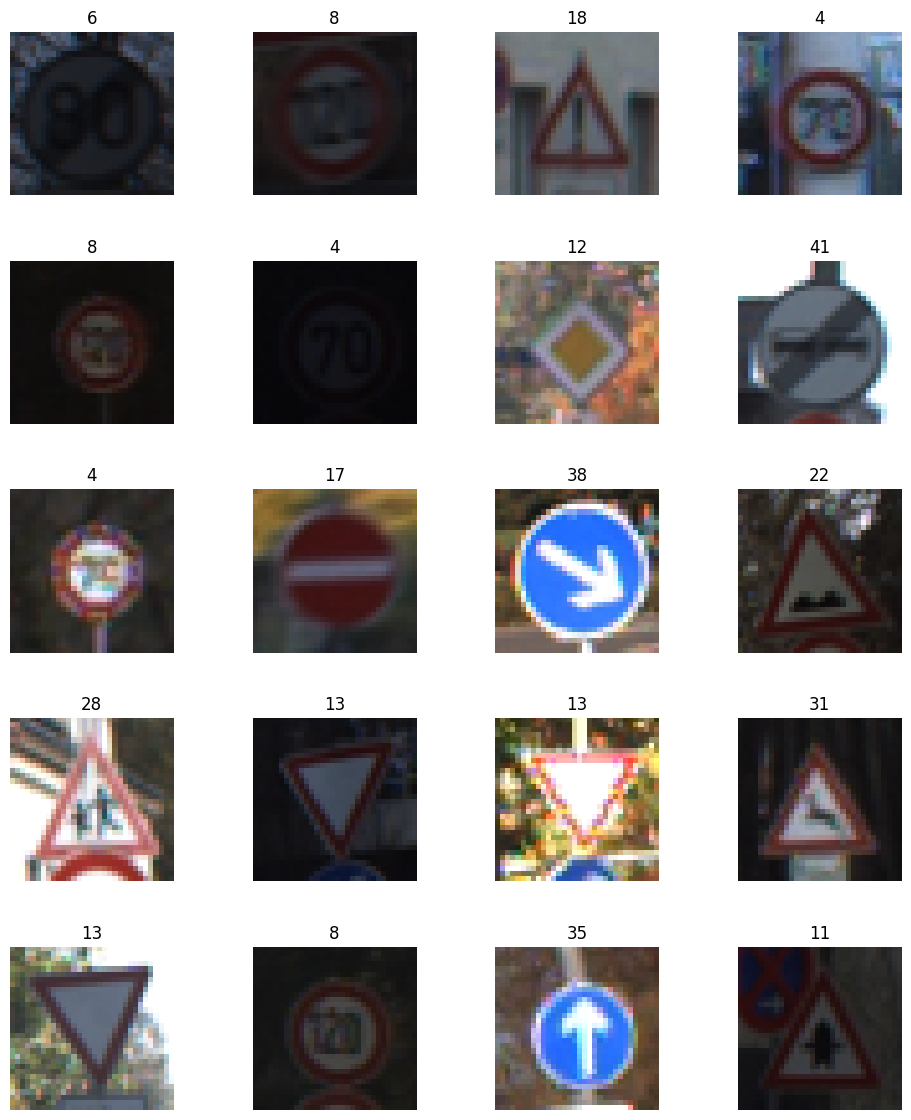

In [63]:
# print 20 sample images with labels

fig, axes = plt.subplots(5, 4, figsize=(12, 14))
axes = axes.ravel()
for i in np.arange(0, 20):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)
plt.show()

In [64]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).long()
X_test = torch.from_numpy(X_test).float()

In [65]:
train_loader = DataLoader(TensorDataset(
    X_train, y_train), batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(TensorDataset(X_test), shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), shuffle=False)

In [66]:
def BuildModel():
    class Model(nn.Module):
        def __init__(self, *args, **kwargs) -> None:
            super().__init__(*args, **kwargs)
            self.conv1 = nn.Conv2d(
                in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(8)
            self.conv2 = nn.Conv2d(
                in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(16)
            self.fc1 = nn.Linear(16*8*8, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 43)
            self.dropout = nn.Dropout(0.3)

        def forward(self, x):
            # reorder image into (channel, height, width)
            x = x.permute(0, 3, 1, 2)
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.max_pool2d(x, 2)
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.max_pool2d(x, 2)
            x = x.reshape(-1, 16*8*8)
            x = self.dropout(x)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)
            return x
    model = Model()
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return model, loss_function, optimizer


model, loss_function, optimizer = BuildModel()


def train(model, loss_function, optimizer, train_loader, val_loader, epochs=20):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    Best_Model = None
    best_val_acc = 0
    for epoch in range(epochs):
        batch_loss = 0
        batch_acc = 0
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = loss_function(z, y)
            loss.backward()
            optimizer.step()
            _, yhat = torch.max(z.data, 1)
            batch_acc += (yhat == y).sum().item()
            batch_loss += loss.item()
        train_acc = batch_acc / len(train_loader.dataset)
        train_loss = batch_loss / len(train_loader)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        val_loss = 0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                z = model(x)
                loss = loss_function(z, y)
                _, yhat = torch.max(z.data, 1)
                val_acc += (yhat == y).sum().item()
                val_loss += loss.item()
        val_acc = val_acc / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        if epoch == 0:
            Best_Model = model
        elif val_acc > best_val_acc:
            Best_Model = model
            best_val_acc = val_acc

        print("Epoch: {} | train_loss: {:.4f} | train_acc: {:.4f} | val_loss: {:.4f} | val_acc: {:.4f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, Best_Model

In [67]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history, Best_Model = train(
    model, loss_function, optimizer, train_loader, val_loader, epochs=20)

Epoch: 0 | train_loss: 1.5281 | train_acc: 0.5290 | val_loss: 0.5147 | val_acc: 0.8272
Epoch: 1 | train_loss: 0.5786 | train_acc: 0.8109 | val_loss: 0.2248 | val_acc: 0.9486
Epoch: 2 | train_loss: 0.3824 | train_acc: 0.8763 | val_loss: 0.1517 | val_acc: 0.9629
Epoch: 3 | train_loss: 0.2883 | train_acc: 0.9102 | val_loss: 0.1106 | val_acc: 0.9726
Epoch: 4 | train_loss: 0.2388 | train_acc: 0.9253 | val_loss: 0.0870 | val_acc: 0.9784
Epoch: 5 | train_loss: 0.2030 | train_acc: 0.9376 | val_loss: 0.0753 | val_acc: 0.9827
Epoch: 6 | train_loss: 0.1749 | train_acc: 0.9459 | val_loss: 0.0735 | val_acc: 0.9806
Epoch: 7 | train_loss: 0.1684 | train_acc: 0.9477 | val_loss: 0.0659 | val_acc: 0.9820
Epoch: 8 | train_loss: 0.1535 | train_acc: 0.9529 | val_loss: 0.0674 | val_acc: 0.9829
Epoch: 9 | train_loss: 0.1380 | train_acc: 0.9569 | val_loss: 0.0542 | val_acc: 0.9855
Epoch: 10 | train_loss: 0.1319 | train_acc: 0.9590 | val_loss: 0.0453 | val_acc: 0.9887
Epoch: 11 | train_loss: 0.1222 | train_acc

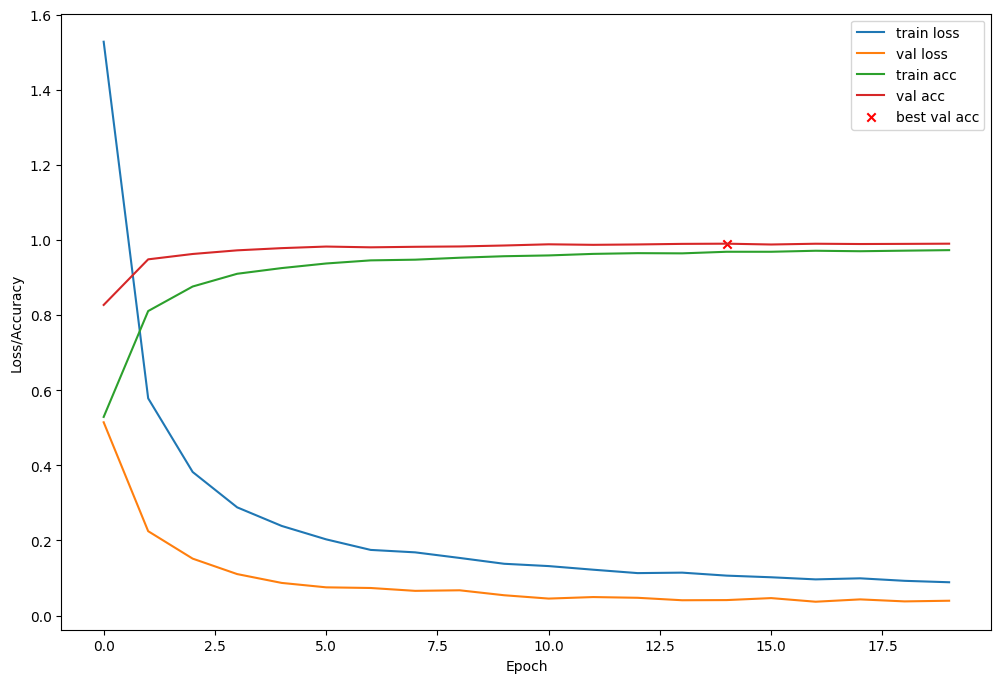

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.plot(train_acc_history, label='train acc')
plt.plot(val_acc_history, label='val acc')
best_epoch = np.argmax(val_acc_history)
plt.scatter(best_epoch, val_acc_history[best_epoch],
            marker='x', c='r', label='best val acc')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

In [84]:
# convert testdata into numpy

test_data = np.array(testdata)
test_data = torch.from_numpy(test_data)
test_data = test_data.type(torch.FloatTensor)

test_loader = DataLoader(dataset=test_data, batch_size=1)


In [86]:
# predict test data 

Best_Model.eval()
yhat = []
with torch.no_grad():
    for x in test_loader:
        z = Best_Model(x)
        _, yhat_batch = torch.max(z.data, 1)
        yhat.append(yhat_batch.numpy())
yhat = np.concatenate(yhat, axis=0)





In [88]:
yhat

array([ 8, 14,  2, ..., 10,  3,  2])

In [91]:
# save the model

torch.save(Best_Model.state_dict(), 'model.pt')
